# Testing Score-Only MCMC sampling

In [1]:
%pylab inline
from nsec.samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm
from nsec.datasets.swiss_roll import get_swiss_roll
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

Populating the interactive namespace from numpy and matplotlib


## Instantiating test distribution

In [2]:
# Create a swiss roll distribution
dist = get_swiss_roll(.5, 2048)

# Define the score function
score = jax.grad(dist.log_prob)

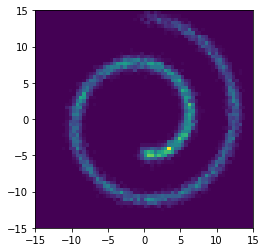

In [3]:
init_samples = dist.sample(10000, seed=jax.random.PRNGKey(0))
hist2d(init_samples[:,0], init_samples[:,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')

## Validating Score-Hamiltonian Monte-Carlo

In [4]:
# Initialize the HMC transition kernel.
num_results = int(20e3)
num_burnin_steps = int(1e3)

# First running SHMC
kernel_shmc = ScoreHamiltonianMonteCarlo(
        target_score_fn=jax.grad(dist.log_prob),
        num_leapfrog_steps=10,
        num_delta_logp_steps=16,
        step_size=0.1)

samples_shmc, is_accepted_shmc = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_samples[1],
      kernel=kernel_shmc,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(1))

In [5]:
# Then running true HMC
kernel_hmc = ScoreHamiltonianMonteCarlo(
        target_score_fn=jax.grad(dist.log_prob),
        num_leapfrog_steps=10,
        num_delta_logp_steps=16,
        step_size=0.1)

samples_hmc, is_accepted_hmc = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_samples[1],
      kernel=kernel_hmc,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(1))

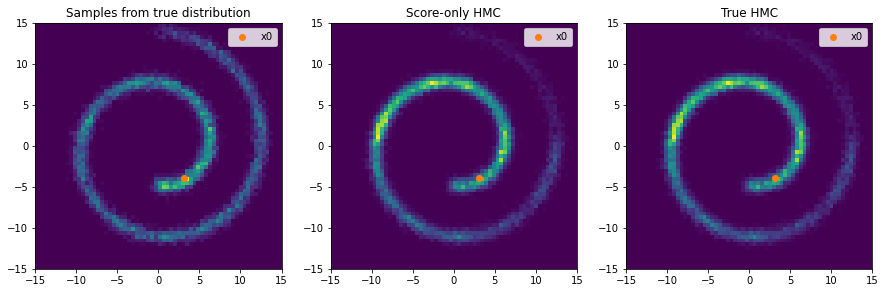

In [6]:
figure(figsize=(15,5))
subplot(131)
hist2d(init_samples[:,0], init_samples[:,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('Samples from true distribution')
legend()
subplot(132)
hist2d(samples_shmc[is_accepted_shmc,0], samples_shmc[is_accepted_shmc,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('Score-only HMC')
legend()
subplot(133)
hist2d(samples_hmc[is_accepted_hmc,0], samples_hmc[is_accepted_hmc,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('True HMC')
legend()

In [7]:
# No difference in number of accepted steps
print(len(where(is_accepted_hmc)[0]), len(where(is_accepted_shmc)[0]))

19947 19947


In [8]:
# Reducing the number of points in the logp integration
kernel_shmc = ScoreHamiltonianMonteCarlo(
        target_score_fn=jax.grad(dist.log_prob),
        num_leapfrog_steps=10,
        num_delta_logp_steps=2,
        step_size=0.1)

samples_shmc, is_accepted_shmc = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_samples[1],
      kernel=kernel_shmc,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(1))

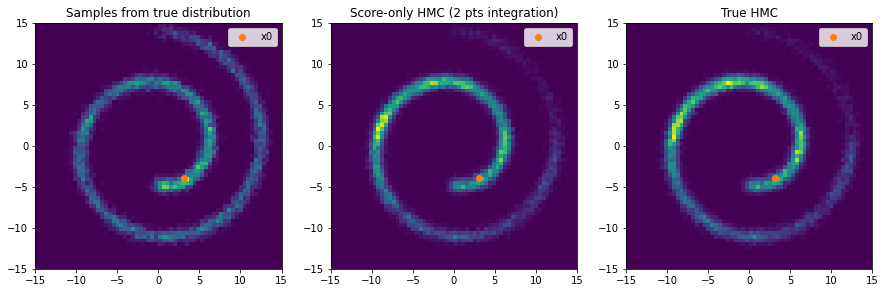

In [9]:
figure(figsize=(15,5))
subplot(131)
hist2d(init_samples[:,0], init_samples[:,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('Samples from true distribution')
legend()
subplot(132)
hist2d(samples_shmc[is_accepted_shmc,0], samples_shmc[is_accepted_shmc,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('Score-only HMC (2 pts integration)')
legend()
subplot(133)
hist2d(samples_hmc[is_accepted_hmc,0], samples_hmc[is_accepted_hmc,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('True HMC')
legend()

In [10]:
# Even with 2 integration points for delta logp, no obvious problem
print(len(where(is_accepted_hmc)[0]), len(where(is_accepted_shmc)[0]))

19947 19880


## Validating Score MALA

In [11]:
# First running SMALA
kernel_smala = ScoreMetropolisAdjustedLangevinAlgorithm(
        target_score_fn=jax.grad(dist.log_prob),
        num_delta_logp_steps=16,
        step_size=0.1)

samples_smala, is_accepted_smala = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_samples[1],
      kernel=kernel_smala,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(1))

In [12]:
kernel_mala = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=dist.log_prob,
        step_size=0.1)

samples_mala, is_accepted_mala = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_samples[1],
      kernel=kernel_mala,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(1))

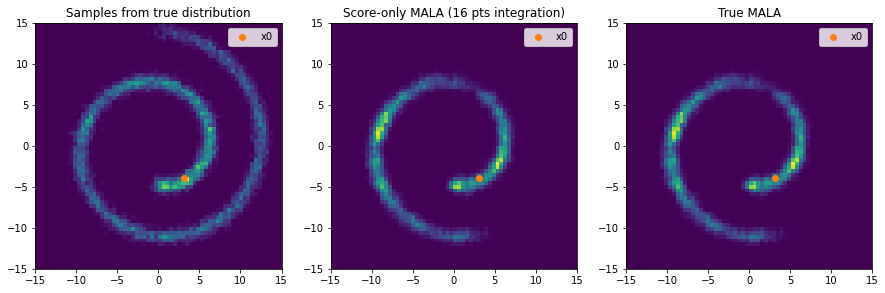

In [13]:
figure(figsize=(15,5))
subplot(131)
hist2d(init_samples[:,0], init_samples[:,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('Samples from true distribution')
legend()
subplot(132)
hist2d(samples_smala[is_accepted_smala,0], samples_smala[is_accepted_smala,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('Score-only MALA (16 pts integration)')
legend()
subplot(133)
hist2d(samples_mala[is_accepted_mala,0], samples_mala[is_accepted_mala,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('True MALA')
legend()

In [14]:
print(len(where(is_accepted_mala)[0]), len(where(is_accepted_smala)[0]))

19555 19555


In [15]:
# Testing with fewer integration steps
kernel_smala = ScoreMetropolisAdjustedLangevinAlgorithm(
        target_score_fn=jax.grad(dist.log_prob),
        num_delta_logp_steps=2,
        step_size=0.1)

samples_smala, is_accepted_smala = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_samples[1],
      kernel=kernel_smala,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(1))

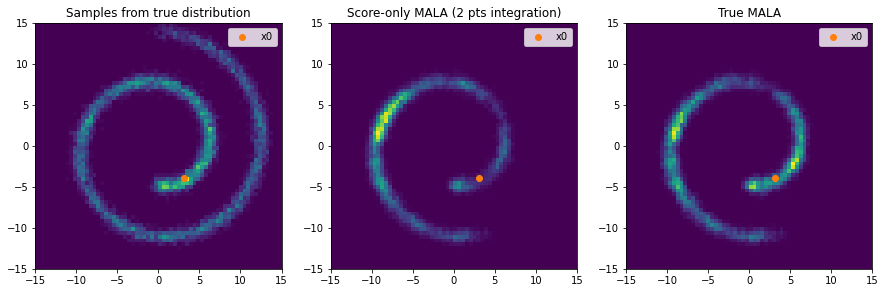

In [16]:
figure(figsize=(15,5))
subplot(131)
hist2d(init_samples[:,0], init_samples[:,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('Samples from true distribution')
legend()
subplot(132)
hist2d(samples_smala[is_accepted_smala,0], samples_smala[is_accepted_smala,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('Score-only MALA (2 pts integration)')
legend()
subplot(133)
hist2d(samples_mala[is_accepted_mala,0], samples_mala[is_accepted_mala,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('True MALA')
legend()

In [17]:
print(len(where(is_accepted_mala)[0]), len(where(is_accepted_smala)[0]))

19555 19574
